# Preparing Data 4 the AE

### Import and function definition

In [1]:
import pandas as pd
import numpy as np
import math
import copy
import matplotlib.pyplot as plt
from scipy.stats import linregress
from scipy.optimize import curve_fit

In [2]:
def Make_img(histo, Xbins, Xmin, Xmax, Ybins, Ymin, Ymax):
    img = np.zeros((102, 102), dtype=np.float32)
    
    for i in range(int(Ybins)+2):
        for j in range(int(Xbins)+2):
            img[i, j] = histo[i*(int(Xbins)+2)+j]
    img = img[1:-1, 1:-1]
    return img
    
def Show2Dimg(img, title='CSC occupancy'):
    img_temp = copy.deepcopy(img)
    cmap = plt.cm.jet
    cmap.set_under(color='white')
    max_=np.max(img_temp)
    img_temp[img_temp==0] = np.nan
    plt.imshow(img_temp, cmap=cmap, vmin=0.0000000001, vmax=max_)
    plt.colorbar()
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.show()
    del img_temp
    #plt.savefig('CSC_occupancy.png')

In [3]:
def Show1Dimg(vx, vy, xfit=None, yfit=None, x=r"Lumi [10$^{33}$ cm$^{-2}$ s$^{-1}$]", y="Occupancy (Hits/LS)", eymin=4, eymax=4, marker='.'):
    plt.figure(figsize=(7, 4))
    plt.plot(vx, vy, marker=marker, linestyle='', markersize=5, label='Data')
    if yfit is not None:
        plt.plot(xfit, yfit, color='red', label='Fit')
        plt.legend()
    plt.xlabel(x, size='14')
    plt.ylabel(y, size='14')
    plt.grid(True)
    plt.ticklabel_format(axis="y", style="sci", scilimits=(eymin,eymax))
    plt.rc('xtick', labelsize='12')
    plt.rc('ytick', labelsize='12')
    plt.title('CMS', fontweight='bold',x=0.12, y=1.0, size=14)
    plt.title('2023 (13.6 TeV)',loc='right', size=14)
    plt.legend()
    plt.show()

def Show1Dhisto(histo, ax,  y="", x="Occupancy (Hits/LS)", x_range=False):
    if x_range:
        ax.hist(histo, histtype='step', bins=40, label='Data', range=(0, 2))
    else:
        ax.hist(histo, histtype='step', bins=40, label='Data')
        ax.ticklabel_format(axis="x", style="sci", scilimits=(4,4))
    ax.set_xlabel(x, size='14')
    ax.set_ylabel(y, size='14')
    ax.grid(True)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    ax.set_title('CMS', fontweight='bold',x=0.12, y=1.0, size=14)
    ax.set_title('2023 (13.6 TeV)',loc='right', size=14)
    ax.legend()

def Entries_vs_R(imgtemp):
    img = imgtemp.copy()
    out = []
    dist = []
    for k in range(80):
        r = (0.5 + k/1.5)
        dist.append(r)
        v = 0
        for i in range(int(len(img))):
            for j in range(int(len(img))):
                dis = math.sqrt((i-50.5)**2 + (j-50.5)**2)
                if abs(dis-r)<0.35:
                    v = v + img[i, j]
                    img[i, j]=0
        out.append(v)
    return dist, out

### Read data and add lumi info

In [4]:
# Read DFs
hRHGlobalm1 = []
hRHGlobalm2 = []
hRHGlobalm3 = []
hRHGlobalm4 = []
for i in range(2):
    hRHGlobalm1.append(pd.read_parquet(f"MonitoringElementsData/hRHGlobalm1_file{i+1}.parquet"))
    hRHGlobalm2.append(pd.read_parquet(f"MonitoringElementsData/hRHGlobalm2_file{i+1}.parquet"))
    hRHGlobalm3.append(pd.read_parquet(f"MonitoringElementsData/hRHGlobalm3_file{i+1}.parquet"))
    hRHGlobalm4.append(pd.read_parquet(f"MonitoringElementsData/hRHGlobalm4_file{i+1}.parquet"))

In [5]:
run_list = []
for i in range(2):
    run_list = np.concatenate((run_list, hRHGlobalm1[i]["fromrun"].unique()))
    run_list = np.concatenate((run_list, hRHGlobalm2[i]["fromrun"].unique()))
    run_list = np.concatenate((run_list, hRHGlobalm3[i]["fromrun"].unique()))
    run_list = np.concatenate((run_list, hRHGlobalm4[i]["fromrun"].unique()))
run_list = np.sort(np.unique(run_list))
print(run_list)

[367312. 367334. 367337. 367352. 367355. 367406. 367413. 367415. 367416.
 367432. 367442. 367443. 367444. 367446. 368678. 368685. 368723. 368724.
 368753. 368762. 368763. 368765.]


In [6]:
# Read lumi info
lumi_list = []
for run in run_list:
    run_str = str(int(run))
    df_temp = pd.read_csv("MonitoringElementsData/"+run_str+"_lumi.csv")
    df_temp["fromrun"] = run
    lumi_list.append(df_temp)
lumi_info = pd.concat(lumi_list)
lumi_info["mean_lumi"]=(lumi_info["init_lumi"]+lumi_info["end_lumi"])/2

In [7]:
lumi_info = lumi_info.rename(columns={'lumisection_number': 'fromlumi'})
print(lumi_info.columns)

Index(['fromlumi', 'start_time', 'end_time', 'delivered_lumi', 'recorded_lumi',
       'init_lumi', 'end_lumi', 'physics_flag', 'fromrun', 'mean_lumi'],
      dtype='object')


In [8]:
for i in range(2):
    hRHGlobalm1[i] = pd.merge(hRHGlobalm1[i], lumi_info, on=['fromrun', 'fromlumi'], how='left')
    hRHGlobalm2[i] = pd.merge(hRHGlobalm2[i], lumi_info, on=['fromrun', 'fromlumi'], how='left')
    hRHGlobalm3[i] = pd.merge(hRHGlobalm3[i], lumi_info, on=['fromrun', 'fromlumi'], how='left')
    hRHGlobalm4[i] = pd.merge(hRHGlobalm4[i], lumi_info, on=['fromrun', 'fromlumi'], how='left')

In [9]:
pd.set_option('display.precision', 3)
display(hRHGlobalm1[0].head())

,fromrun,fromlumi,hname,metype,histo,entries,Xmax,Xmin,Xbins,Ymax,Ymin,Ybins,start_time,end_time,delivered_lumi,recorded_lumi,init_lumi,end_lumi,physics_flag,mean_lumi
0,367337,465,CSC/CSCOfflineMonitor/recHits/hRHGlobalm1,6,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",67610,800.0,-800.0,100,800.0,-800.0,100,2023-05-11 15:49:57,2023-05-11 15:50:20,322.280,295.531,12.985,12.973,True,12.979
1,367337,466,CSC/CSCOfflineMonitor/recHits/hRHGlobalm1,6,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",72453,800.0,-800.0,100,800.0,-800.0,100,2023-05-11 15:50:20,2023-05-11 15:50:44,322.582,295.822,12.973,12.960,True,12.967
2,367337,471,CSC/CSCOfflineMonitor/recHits/hRHGlobalm1,6,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",60885,800.0,-800.0,100,800.0,-800.0,100,2023-05-11 15:52:17,2023-05-11 15:52:40,324.091,297.234,12.918,12.940,True,12.929
3,367337,472,CSC/CSCOfflineMonitor/recHits/hRHGlobalm1,6,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",51753,800.0,-800.0,100,800.0,-800.0,100,2023-05-11 15:52:40,2023-05-11 15:53:03,324.392,297.448,12.940,12.937,True,12.938
4,367337,473,CSC/CSCOfflineMonitor/recHits/hRHGlobalm1,6,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",69160,800.0,-800.0,100,800.0,-800.0,100,2023-05-11 15:53:03,2023-05-11 15:53:27,324.694,297.736,12.937,12.935,True,12.936


In [10]:
hRHGlobalm1 = (pd.concat(hRHGlobalm1)).reset_index()
hRHGlobalm2 = (pd.concat(hRHGlobalm2)).reset_index()
hRHGlobalm3 = (pd.concat(hRHGlobalm3)).reset_index()
hRHGlobalm4 = (pd.concat(hRHGlobalm4)).reset_index()

### Occupancy Plots

#### Occupancy per chamber

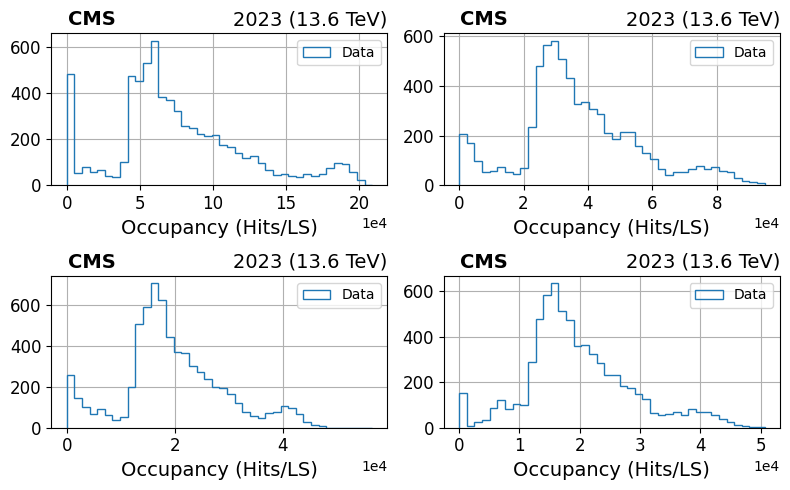

In [11]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8, 5))
Show1Dhisto(hRHGlobalm1['entries'], ax1)
Show1Dhisto(hRHGlobalm2['entries'], ax2)
Show1Dhisto(hRHGlobalm3['entries'], ax3)
Show1Dhisto(hRHGlobalm4['entries'], ax4)
plt.tight_layout()
plt.show()

[77009.8291709768, 37307.63336781439, 19715.45382000887, 19819.416284912073]


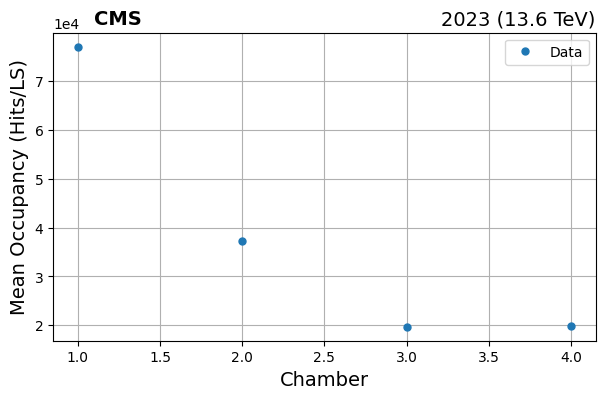

In [12]:
mean_entries_per_chamber = [hRHGlobalm1['entries'].mean(), hRHGlobalm2['entries'].mean(), hRHGlobalm3['entries'].mean(), hRHGlobalm4['entries'].mean()]
print(mean_entries_per_chamber)
chamber=[1,2,3,4]
Show1Dimg(chamber, mean_entries_per_chamber, x="Chamber", y="Mean Occupancy (Hits/LS)", marker='o')

#### Occupancy vs Lumi

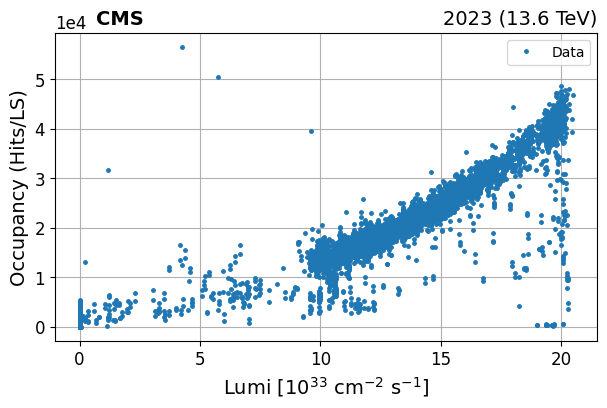

In [13]:
Show1Dimg(hRHGlobalm3['mean_lumi'], hRHGlobalm3['entries'])

In [14]:
def exponential(x, a, b, c):
    return a * np.exp(b * x) -c
    
def fit(df, cut):
    x = df['mean_lumi'][df['entries']/cut > (df['mean_lumi']-7)].values
    y = df['entries'][df['entries']/cut > (df['mean_lumi']-7)].values
    fit_param, _ = curve_fit(exponential, x, y)
    a_fit, b_fit, c_fit = fit_param
    print(fit_param)
    df['scaled_histo']= df['histo']/exponential(df['mean_lumi'], a_fit, b_fit, c_fit)
    df['scaled_entries']= df['entries']/exponential(df['mean_lumi'], a_fit, b_fit, c_fit)
    xfit=np.linspace(0, 21, 100)
    Show1Dimg(x, y, xfit, exponential(xfit, a_fit, b_fit, c_fit))
    #np.savetxt('fit_param.txt', fit_param)

8506
[2.30781114e+04 1.11500354e-01 2.51130597e+04]


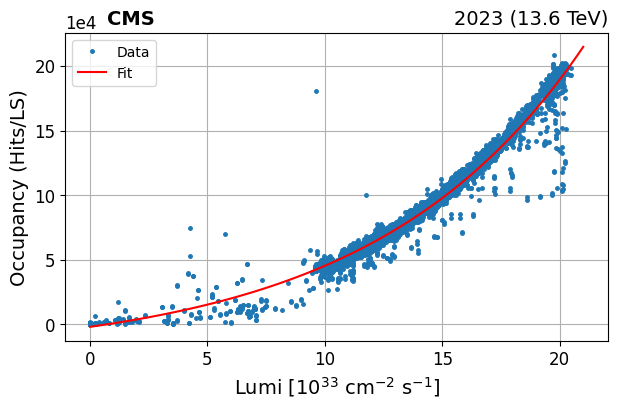

8506
[1.35668981e+04 9.57148156e-02 1.07804735e+04]


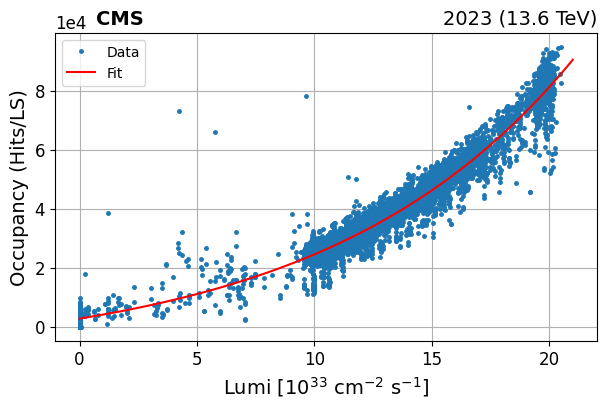

[8.20698421e+03 8.90279260e-02 6.76221389e+03]


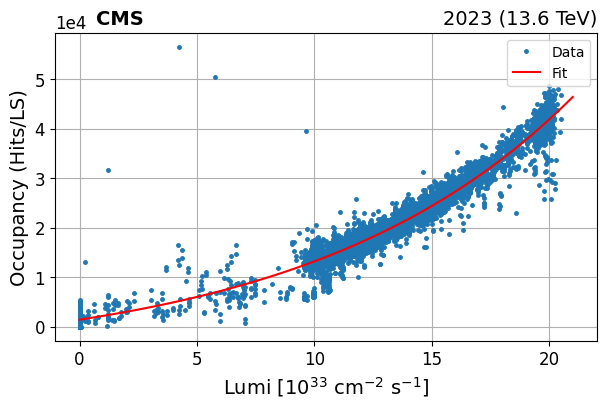

[ 3.08645520e+03  1.26247280e-01 -3.02366323e+03]


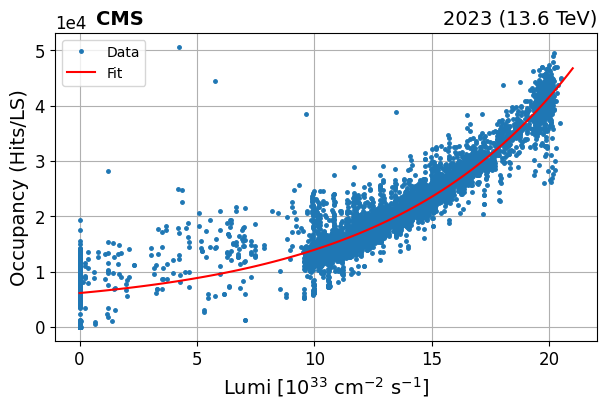

In [15]:
num_0 = np.count_nonzero(hRHGlobalm1['histo'][0] == 0)
print(num_0)
fit(hRHGlobalm1, mean_entries_per_chamber[0]/10)
num_0 = np.count_nonzero(hRHGlobalm1['histo'][0] == 0)
print(num_0)
fit(hRHGlobalm2, mean_entries_per_chamber[1]/10)
fit(hRHGlobalm3, mean_entries_per_chamber[2]/10)
fit(hRHGlobalm4, mean_entries_per_chamber[3]/10)

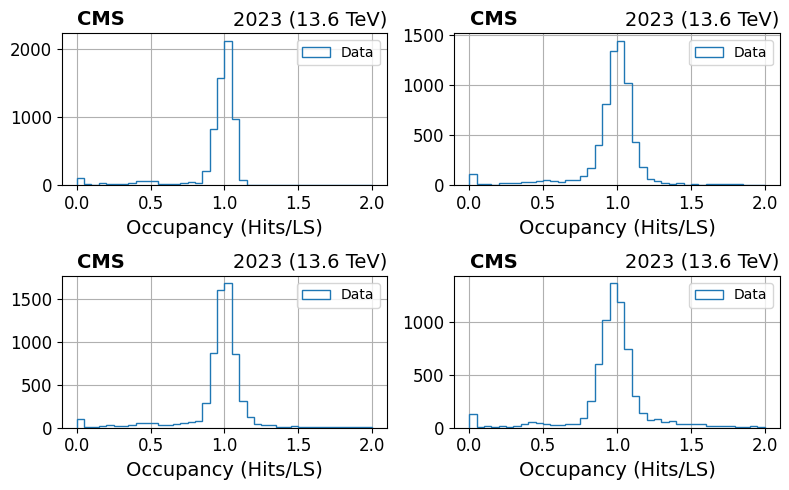

In [16]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8, 5))
Show1Dhisto(hRHGlobalm1['scaled_entries'], ax1, x_range=True)
Show1Dhisto(hRHGlobalm2['scaled_entries'], ax2, x_range=True)
Show1Dhisto(hRHGlobalm3['scaled_entries'], ax3, x_range=True)
Show1Dhisto(hRHGlobalm4['scaled_entries'], ax4, x_range=True)
plt.tight_layout()
plt.show()

### Sum over LS

Mean lumi: 18.567816862


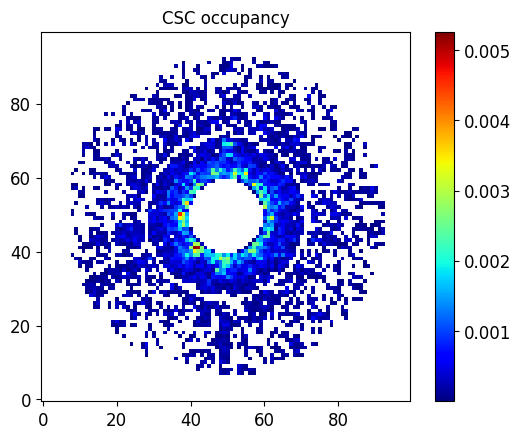

Mean lumi: 10.806528222499999


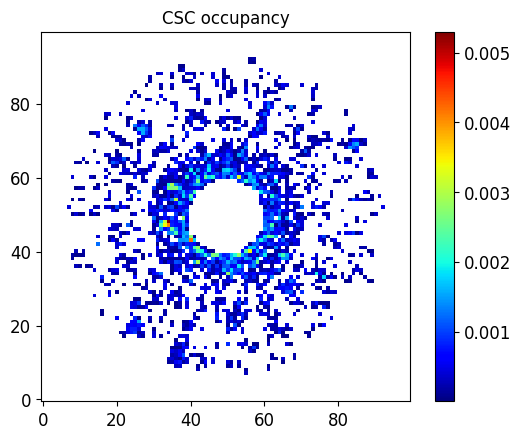

In [17]:
print("Mean lumi:", hRHGlobalm3["mean_lumi"][1050])
img = Make_img(hRHGlobalm3['scaled_histo'][1050], hRHGlobalm1['Xbins'][0], hRHGlobalm1['Xmin'][0], hRHGlobalm1['Xmax'][0], hRHGlobalm1['Ybins'][0], hRHGlobalm1['Ymin'][0], hRHGlobalm1['Ymax'][0])
Show2Dimg(img)
print("Mean lumi:", hRHGlobalm3["mean_lumi"][2000])
img = Make_img(hRHGlobalm3['scaled_histo'][2000], hRHGlobalm1['Xbins'][0], hRHGlobalm1['Xmin'][0], hRHGlobalm1['Xmax'][0], hRHGlobalm1['Ybins'][0], hRHGlobalm1['Ymin'][0], hRHGlobalm1['Ymax'][0])
Show2Dimg(img)

In [18]:
def hadd_img(df, lumiperdiv=20):
    count = 0
    summed_img = []
    df_temp = pd.DataFrame(columns=['scaled_histo'])
    for it in range(len(df)):
        new_row = {'scaled_histo': df['scaled_histo'][it]}
        df_temp = pd.concat([df_temp, pd.DataFrame([new_row])], ignore_index=True)
        del new_row
        count = count + 1
        if count == lumiperdiv:
            sumofH = sum(df_temp['scaled_histo'].head(lumiperdiv))
            summed_img.append(Make_img(sumofH, df['Xbins'][0], df['Xmin'][0], df['Xmax'][0], df['Ybins'][0], df['Ymin'][0], df['Ymax'][0]))
            count = 0
            df_temp = pd.DataFrame(columns=['scaled_histo'])
    print("Total imgs: ",len(summed_img))
    return summed_img

In [19]:
hRHGlobalm1_img = hadd_img(hRHGlobalm1[hRHGlobalm1["mean_lumi"]>9].reset_index())
hRHGlobalm2_img = hadd_img(hRHGlobalm2[hRHGlobalm2["mean_lumi"]>9].reset_index())
hRHGlobalm3_img = hadd_img(hRHGlobalm3[hRHGlobalm3["mean_lumi"]>9].reset_index())
hRHGlobalm4_img = hadd_img(hRHGlobalm4[hRHGlobalm4["mean_lumi"]>9].reset_index())

Total imgs:  309
Total imgs:  309
Total imgs:  309
Total imgs:  309


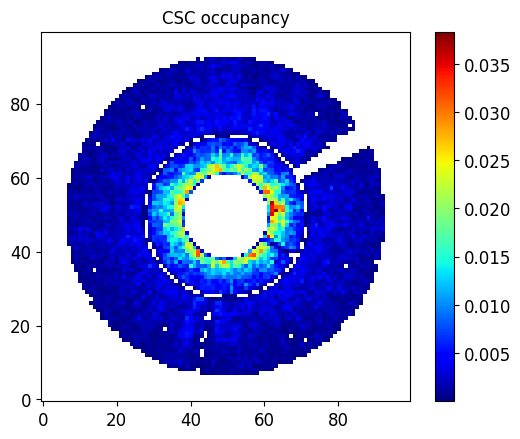

In [20]:
Show2Dimg(hRHGlobalm4_img[10])

In [21]:
np.save('data.npy', [hRHGlobalm1_img, hRHGlobalm2_img, hRHGlobalm3_img, hRHGlobalm4_img])

In [22]:
vettori_caricati = np.load('data.npy')

In [23]:
print(vettori_caricati[2][10])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


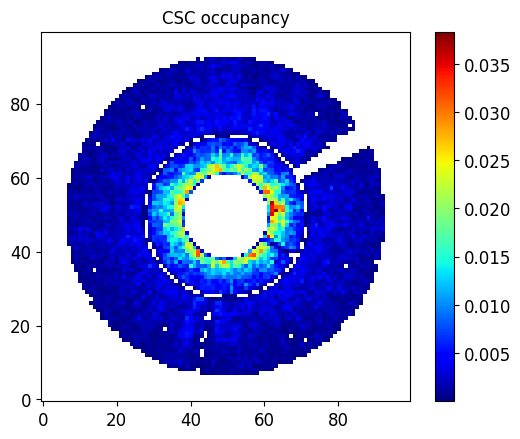

In [24]:
Show2Dimg(vettori_caricati[3][10])